In [26]:
#imports
import pandas as pd
import numpy as np
from datetime import datetime
from statistics import mode
import matplotlib.pyplot as plt
import pickle
from collections import Counter

In [28]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [29]:
import time
import warnings
warnings.filterwarnings("ignore")
path = "drive/MyDrive/Booking challenge/"

In [30]:
def drop_timesteps(t, len_trip, proportion=4):
    max_id_to_drop = len(t) // proportion
    n = int(max_id_to_drop * pow(np.random.rand(), 0.3)) + 1 #random number of indexes to drop
    for i in range(n):
        to_skip = int(len_trip * pow(np.random.rand(), 0.3)) #more likely to skip a step towrds the end to add confusion
        t = np.delete(t, to_skip, axis=0)
        len_trip -= 1 #one time step was removed, so the trip is 1 time step smaller
        
    return t, len_trip

In [31]:
from numpy import savez_compressed, load
import random
def getData(filename1, filename2, filename3, batch_size=512, skip=0.2, train=True):
    #initiate a batch count for each size of trips
    batch_count = {k: 0 for k in range(50)}
    inputs = {k: [] for k in range(50)}
    targets = {k: [] for k in range(50)}
    while True:
        #load files
        trip_sequences = load(filename1, allow_pickle=True)["arr_0"]
        trip_infos = load(filename2, allow_pickle=True)["arr_0"]
        predictions = load(filename3, allow_pickle=True)["arr_0"]
        
        if train:
          random.seed()
          #Shuffle
          to_shuffle = list(zip(trip_sequences, trip_infos, predictions))
          random.shuffle(to_shuffle)
          trip_sequences, trip_infos, predictions = zip(*to_shuffle)

        #trip_sequences = np.array(trip_sequences)
        #trip_infos = np.array(trip_infos) 
        predictions = np.array(predictions, dtype="int32")
        
        for i in range(len(trip_sequences)):
          
            #consider trip i
            trip_sequence = trip_sequences[i]
            trip_info = trip_infos[i]
            prediction = predictions[i]
            len_trip = len(trip_sequence)
            
            if (train) & (len_trip > 3):
              #randomly skip one time step:
              random.seed()
              n = np.random.randint(100)
              if n / 100 < skip:
                #random step to skip:
                trip_sequence, len_trip = drop_timesteps(trip_sequence, len_trip)
            
            #add info to corresponding  size
            inputs[len_trip].append([trip_sequence, trip_info])
            targets[len_trip].append(prediction)
            batch_count[len_trip] += 1
            
            if batch_count[len_trip] == batch_size:
                X_trip = np.array([t[0] for t in inputs[len_trip]], dtype='float32')
                X_info = np.array([t[1] for t in inputs[len_trip]], dtype='float32')
                y = np.array(targets[len_trip]).reshape(batch_size,)
                #yield the data to feed the 
                yield [X_trip, X_info], y
                inputs[len_trip] = []
                targets[len_trip] = []
                batch_count[len_trip] = 0
               
               

In [ ]:
y_t = load(path+"y_train.npz", allow_pickle=True)["arr_0"]
labels_dict = {k: 0 for k in range(39901)}
for k, v in dict(Counter(y_t)).items():
    labels_dict[k] = v

import numpy as np
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict, mu=1):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
      if labels_dict[key] == 0:
        # key city is never a target in the train set, we can never predict it
        class_weight[key] = 0
      else:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score

    return class_weight


weights = create_class_weight(labels_dict)


In [ ]:
#load ngram model
with open(path+"ngram.pkl", "rb") as f:
    dct = pickle.load(f)

In [ ]:
from collections import defaultdict
#transform it into def dict
ngram = defaultdict(dict, {k: defaultdict(int, dct[k]) for k in dct.keys()})

In [ ]:
def ngram_predict(test_trip, return_top=4):
    predictions = {k: 0 for k in range(39901)}
    i = 0
    while i < len(test_trip):
        trip_to_consider = test_trip[i:]
        preds = dict(ngram[tuple(trip_to_consider)])
        for k in preds.keys():
            predictions[k] += preds[k] * len(trip_to_consider)
        i += 1
    
    #at this point, if no prediction is made, try it without the last city
    if sum(predictions.values()) == 0:
        return predict(test_trip[:-1])
    
    #Now, we calculate the sum of all values
    total = sum(predictions.values(), 0.0)
    #divide each value by it to get a proportion
    predictions = {k: v / total for k, v in predictions.items()}
    return pd.Series(predictions).values



In [32]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, concatenate, Input, TimeDistributed, Layer, Bidirectional, Softmax, Multiply, Lambda, GRU
from tensorflow.keras.regularizers import L2
from tensorflow.keras import activations
import tensorflow.keras.backend as K

In [33]:
#Parameters
reg = L2(l2=0.0001)
embedding_size = 300
num_cities = 39901
info_features_length = 4
dropout = 0.5

trips_sequences_input = Input(shape=(None,)) 
info_input = Input(shape=(info_features_length))




#First RNN on cities with Embeddings
emb_layer = Embedding(output_dim=embedding_size, input_dim=num_cities, input_length=None,
                      mask_zero=False, name="city_embeddings")

emb_cities = emb_layer(trips_sequences_input) 
lstm_cities_1 = GRU(100, dropout=dropout, return_sequences=True,
                    kernel_regularizer=reg)(emb_cities)
  

lstm_cities_2 = GRU(100, dropout=dropout, return_sequences=True,
                  kernel_regularizer=reg)(lstm_cities_1)


#Add attention layer
attention=TimeDistributed(Dense(1))(lstm_cities_2)
attention=Softmax(axis=1)(attention)
context=Multiply()([attention,lstm_cities_2])
out=Lambda(lambda x: K.sum(x,axis=1))(context)    



concat = concatenate([out, info_input]) 


#Combine two RNN with features
#pre_output = Dense()
output = Dense(num_cities, activation='softmax')(concat) 


 
model = Model(inputs=[trips_sequences_input, info_input], outputs=[output])


In [34]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
city_embeddings (Embedding)     (None, None, 300)    11970300    input_5[0][0]                    
__________________________________________________________________________________________________
gru_4 (GRU)                     (None, None, 100)    120600      city_embeddings[0][0]            
__________________________________________________________________________________________________
gru_5 (GRU)                     (None, None, 100)    60600       gru_4[0][0]                      
____________________________________________________________________________________________

In [35]:
import tensorflow.keras.backend as K
import tensorflow as tf
def custom_loss(model=model, embed_dim=embedding_size, alpha=3, batch_size=512):

    def loss(y_true, y_pred, alpha=alpha):
        """
        This custom loss has an objective of tying embeddings weights to the usual sparse loss.
        """
        #Normal pred error, shape (batch,)
        pred_error = K.sparse_categorical_crossentropy(y_true, y_pred)

        #retrieve learned embeddings, shape (Vocab, embed_size)
        embed_matrix = model.get_layer("city_embeddings").weights[0]

        #calculate the predicted embedding, (batch,Vocab) x (Vocab, embed size) 
        predicted_embedding = tf.matmul(y_pred, embed_matrix, transpose_a=False, transpose_b=False)        
        #predicted embedding is a vector (batch, embeddsize)
        
        #retrieve embedding vector of pred, shape (batch_size, 1, embed_size)
        actual_embedding = tf.gather(embed_matrix, y_true)
        actual_embedding = K.reshape(actual_embedding, (batch_size,embed_dim))
        
        #calculate divergence or cosine?
        kull_divergence = tf.keras.losses.kullback_leibler_divergence(predicted_embedding, actual_embedding)
        #cosine_error = tf.keras.losses.cosine_similarity(predicted_embedding, actual_embedding)

        return pred_error + (alpha * kull_divergence)
    
    return loss

In [36]:
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy
learning_rate = 0.0003
batch_size = 512
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=.25)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",        #custom_loss(model, embedding_size, 1, batch_size), # Call the loss function with the model
              metrics=['sparse_top_k_categorical_accuracy'])



from tensorflow.keras.callbacks import ModelCheckpoint
filepath=path+"improvement-{epoch:02d}-{val_sparse_top_k_categorical_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_sparse_top_k_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [37]:
num_train_samples = 1257599
num_val_samples = 17913



train_generator = getData(path+"X_trip_new.npz", path+"X_info_new.npz",
                          path+"y_new.npz", batch_size=batch_size, skip=0.3) #30% to mask some timesteps if the trip longer than 3 destinations


val_generator = getData(path+"X_val_cities.npz", path+"X_val_info.npz",
                          path+"y_val.npz", batch_size=batch_size, train=False)

In [38]:
history = model.fit(train_generator,
        steps_per_epoch=num_train_samples // batch_size,
        epochs=30,
        validation_data=val_generator,
        validation_steps=num_val_samples // batch_size,
                    batch_size=batch_size, 
                    callbacks=callbacks_list,                
)

Epoch 1/30
2456/2456 [==============================] - 247s 99ms/step - loss: 8.3077 - sparse_top_k_categorical_accuracy: 0.0528 - val_loss: 7.0118 - val_sparse_top_k_categorical_accuracy: 0.1870

Epoch 00001: val_sparse_top_k_categorical_accuracy improved from -inf to 0.18704, saving model to drive/MyDrive/Booking challenge/improvement-01-0.19.hdf5
Epoch 2/30
2456/2456 [==============================] - 263s 107ms/step - loss: 6.6872 - sparse_top_k_categorical_accuracy: 0.1519 - val_loss: 6.0048 - val_sparse_top_k_categorical_accuracy: 0.3231

Epoch 00002: val_sparse_top_k_categorical_accuracy improved from 0.18704 to 0.32307, saving model to drive/MyDrive/Booking challenge/improvement-02-0.32.hdf5
Epoch 3/30
2456/2456 [==============================] - 258s 105ms/step - loss: 5.7880 - sparse_top_k_categorical_accuracy: 0.2470 - val_loss: 5.5270 - val_sparse_top_k_categorical_accuracy: 0.3736

Epoch 00003: val_sparse_top_k_categorical_accuracy improved from 0.32307 to 0.37362, saving

In [40]:
X = model.get_layer("city_embeddings").weights[0].numpy()

In [41]:
X[0] @ X[3]

0.8503196

In [42]:
from sklearn.decomposition import PCA
pca = PCA(2)

In [43]:
X_centered = X - X.mean(axis=0)

In [44]:
pca.fit(X_centered)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [45]:
X_pca = pca.transform(X_centered)

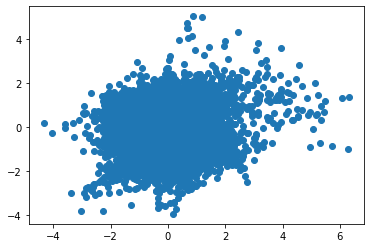

In [46]:
import matplotlib.pyplot as plt
plt.scatter(X_pca[:,0], X_pca[:,1])

In [47]:
pca.explained_variance_ratio_

array([0.17339315, 0.14541857], dtype=float32)

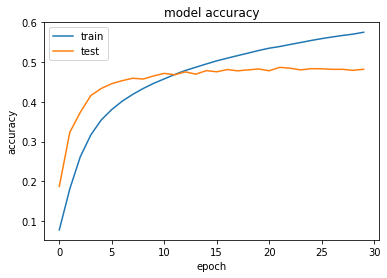

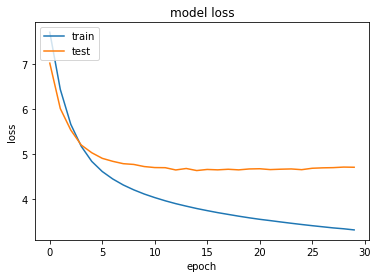

In [39]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['sparse_top_k_categorical_accuracy'])
plt.plot(history.history['val_sparse_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()